In [113]:
import tensorflow as tf

In [114]:
import numpy as np

In [115]:
%pip install librosa


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [116]:
import librosa

In [117]:
import matplotlib.pyplot as plt

In [118]:
import os

In [119]:
marvin = os.path.join('marvin','0a7c2a8d_nohash_0.wav')
marvin_f , s = librosa.load(marvin, sr=16000)#normalization done by librosa
print(s)

16000


In [120]:
print(len(marvin_f))

16000


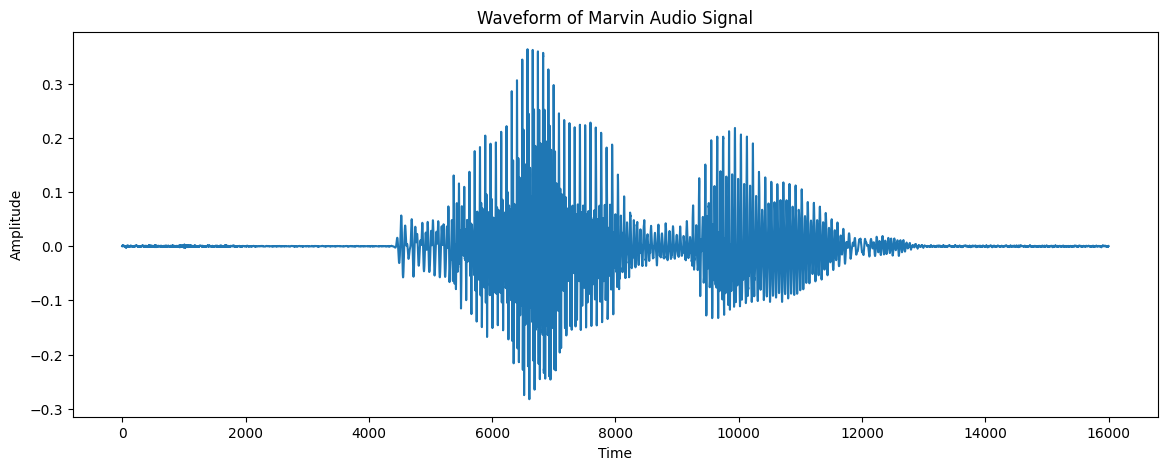

In [121]:
plt.figure(figsize=(14, 5))
plt.plot(marvin_f)
plt.title('Waveform of Marvin Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [122]:
noise = os.path.join('doing_the_dishes.wav')
noise_f , _ = librosa.load(noise, sr=16000)
print(len(noise_f))# 95 sec clip

1522930


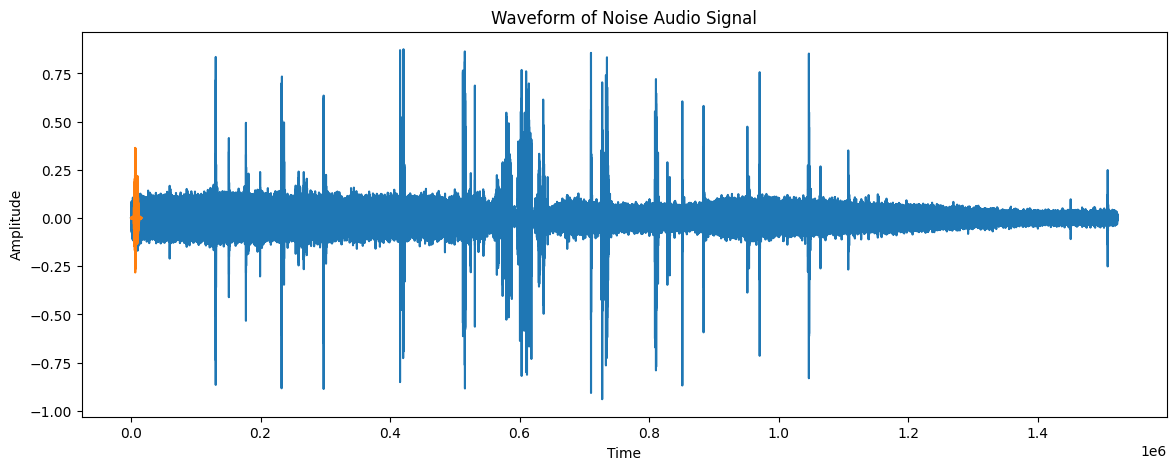

In [123]:
plt.figure(figsize=(14, 5))
plt.plot(noise_f)
plt.plot(marvin_f)
plt.title('Waveform of Noise Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [124]:
import soundfile as sf

In [125]:
#spliting the noise clips
for i in range(0,len(noise_f),16000):
    clip = noise_f[i:i+16000]
    if len(clip) == 16000:
        sf.write(f"chunk_{i//16000}.wav", clip, s)

In [126]:

doing_the_dishes_1 = os.path.join('doing_the_dishes',f'chunk_60.wav')
dishes_1 , _= librosa.load(doing_the_dishes_1, sr=16000)
len(dishes_1)

16000

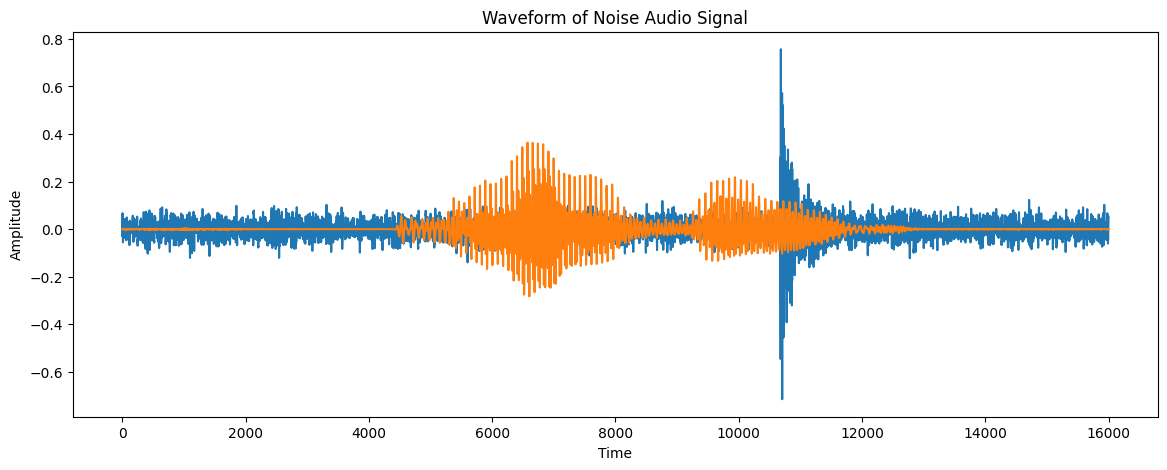

In [127]:
#visualizng the dishes 1 second clip against marvin
plt.figure(figsize=(14, 5))
plt.plot(dishes_1)
plt.plot(marvin_f)
plt.title('Waveform of Noise Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [149]:
FRAME_SIZE = 512
HOP_LENGTH = 216

In [152]:
S_scale = librosa.stft(marvin_f, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

In [154]:
S_scale.shape

(257, 75)

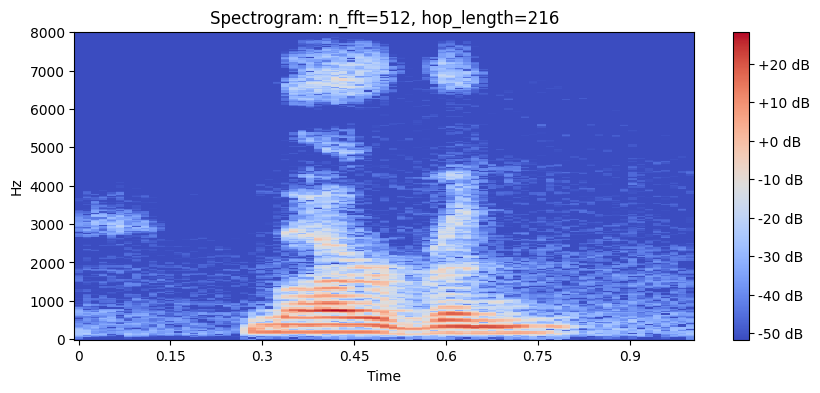

In [156]:
#plotting the spectogram
S_db = librosa.amplitude_to_db(abs(S_scale))

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=s, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title(f"Spectrogram: n_fft={FRAME_SIZE}, hop_length={HOP_LENGTH}")
plt.show()

In [128]:
#MFCC's,delta MFCC's, delta delta MFCC's - Extracting features from the audio data
mfcc_marvin = librosa.feature.mfcc(y=marvin_f, sr=16000)
mfcc_marvin.shape

(20, 32)

In [129]:
mfcc_marvin_delta = librosa.feature.delta(mfcc_marvin)
mfcc_marvin_delta2 = librosa.feature.delta(mfcc_marvin,order=2)
mfcc_marvin_delta.shape


(20, 32)

In [130]:
mfcc_marvin_delta2.shape

(20, 32)

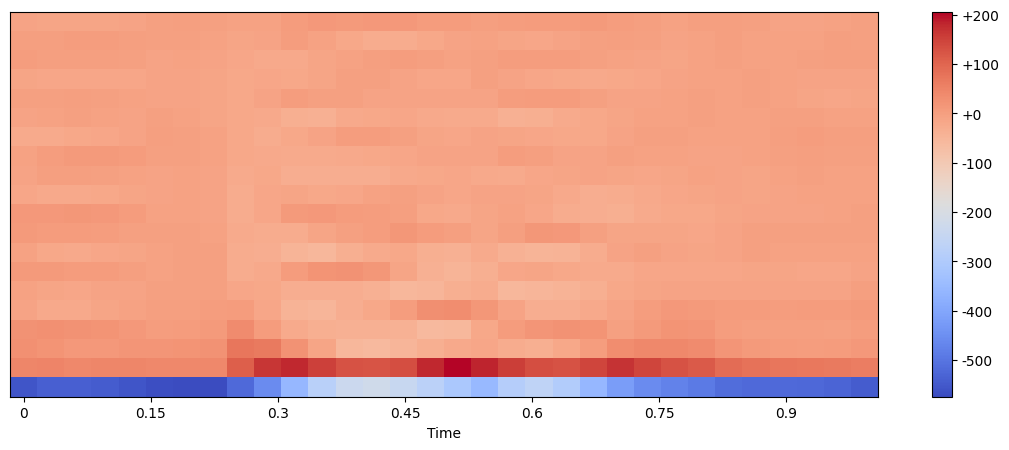

In [131]:
#plotting the MFcc graph for the target audio

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_marvin, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

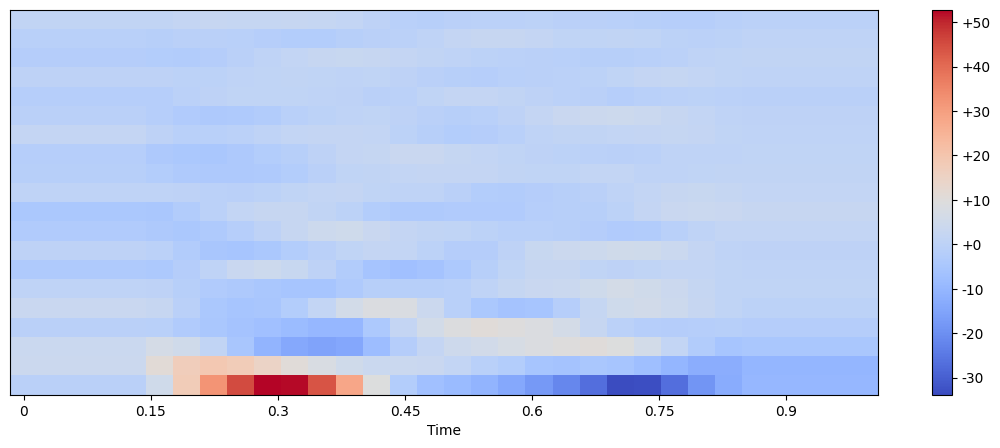

In [132]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_marvin_delta, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

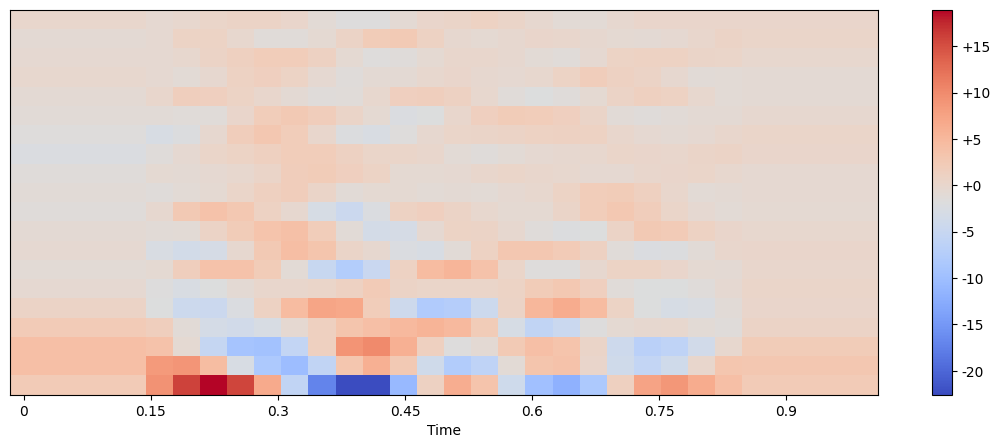

In [133]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_marvin_delta2, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

In [134]:
mfcc_noise = librosa.feature.mfcc(y=dishes_1,sr=16000)
mfcc_noise.shape

(20, 32)

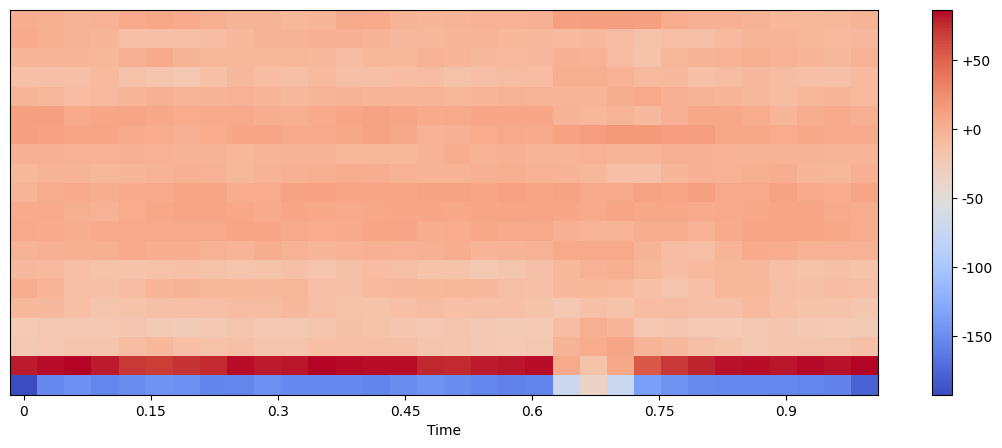

In [135]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_noise, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

In [136]:
#creating a positive and negative dataset using marvin and dishes noise
neg = tf.data.Dataset.list_files(os.path.join('doing_the_dishes') + '/*.wav')
pos = tf.data.Dataset.list_files(os.path.join('marvin') + '/*.wav')
pos = pos.take(100)

positives = pos.map(lambda x: (x, tf.constant(1)))
negatives = neg.map(lambda x: (x, tf.constant(0)))

In [137]:
positives.as_numpy_iterator().next()

(b'marvin/97f4c236_nohash_0.wav', np.int32(1))

In [138]:
negatives.as_numpy_iterator().next()

(b'doing_the_dishes/chunk_13.wav', np.int32(0))

In [139]:
data = positives.concatenate(negatives)

In [140]:
data = data.shuffle(200)
labels = []
for _, y in data.take(100):
    labels.append(y.numpy())

print("positives:", labels.count(1))
print("negatives:", labels.count(0))


positives: 49
negatives: 51


In [141]:
data.as_numpy_iterator().next()

(b'doing_the_dishes/chunk_4.wav', np.int32(0))

In [142]:
#creating a  function to extract feature from data
def ex_features(filepath):
    filepath = filepath.numpy().decode("utf-8")
    file,sr = librosa.load(filepath,sr=16000)
    #MFCC
    mfcc = librosa.feature.mfcc(y = file , n_mfcc = 13 , sr = sr)


    #Delta MFCC
    delta_mfcc = librosa.feature.delta(mfcc)


    #Delta Delta MFCC
    delta2_mfcc = librosa.feature.delta(mfcc,order=2)


    mfcc = mfcc.T
    delta_mfcc = delta_mfcc.T
    delta2_mfcc = delta2_mfcc.T

    features = np.stack([mfcc, delta_mfcc, delta2_mfcc], axis=-1)

    return features.astype(np.float32)





In [143]:
#creating a function to preprocess the data
def preprocess(path,label):
    feature_matrix = tf.py_function(func=ex_features, inp=[path],Tout = tf.float32)
    feature_matrix.set_shape([32,13,3])
    return feature_matrix , label


In [144]:
data = data.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)

In [145]:
data = data.cache()

In [147]:
#looking how it looking
x, y = next(iter(data))
x.shape, y.shape


2026-01-23 05:41:16.841364: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(TensorShape([32, 13, 3]), TensorShape([]))